# CSGY 6953 Deep Learning Final Project
In this project, we will implement a dual-encoder model for image search. Our model will be trained so that it embeds both images and texts into the same space, and importantly, maps relevant data to be close each other in the embedding space. This will be done by developing two encoders, one for image processing and the other for text encoding, and training them by a similarity-based loss function.<br>
<br>
In this note book, we investigate the effect of learning rate in our model. In our base model, we set it to $0.0005$, but the model's performance may be improved by optimizeing it to a fixed value, or changing it adaptively.

## 1. Preparation
As always, prepare the dataset for the training.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import sys

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
with open(f"drive/My Drive/finalproj/data/dataset.pkl", "rb") as f:
    dataset = pickle.load(f)

In [ ]:
# Split them into training and test sets.
train_pct = 0.7
threshold = int(len(dataset["images"]) * train_pct)
train_images = dataset["images"][:threshold]
train_texts = dataset["texts"][:threshold * 10]
test_images = dataset["images"][threshold:]
test_texts = dataset["texts"][threshold * 10:]
print(f"Training images: ", len(train_images))
print(f"Training texts: ", len(train_texts))
print(f"Test images: ", len(test_images))
print(f"Test texts: ", len(test_texts))

Training images:  3150
Training texts:  31500
Test images:  1350
Test texts:  13500


In [ ]:
import torch
from torch.utils.data import DataLoader

In [ ]:
# These are the libraries we developed from scratch for this project.
sys.path.append("drive/My Drive/finalproj")
import EncoderHeads, Dataset, utils

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("The device is " + device.type + ".")

The device is cuda.


In [ ]:
embed_dim = 256
max_len = 60 # Recommend: 46 for GloVe, 60 for BERT (though the maximum is 146)
image_encoder_model = "InceptionV3"
text_encoder_model = "BERT"
image_head_model = "FC"
text_head_model = "FC"

TrainingDataset = Dataset.DualEncoderDataset(train_images, train_texts, device, image_encoder_model, text_encoder_model, max_len=max_len, neg_rate=4)
TestDataset = Dataset.DualEncoderDataset(test_images, test_texts, device, image_encoder_model, text_encoder_model, max_len=max_len, neg_rate=4)
TrainingDataset.print_num_params()


Preprocessing image data...


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

100%|██████████| 99/99 [00:21<00:00,  4.56it/s]


Preprocessing text data...


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

100%|██████████| 985/985 [00:47<00:00, 20.88it/s]



Preprocessing image data...


100%|██████████| 43/43 [00:06<00:00,  7.01it/s]


Preprocessing text data...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 422/422 [00:20<00:00, 21.03it/s]


=== Image Encoder ===
  Pretrained Parameters: 25,112,264

=== Text Encoder ===
  Pretrained Parameters: 109,482,240


## 2. Random Search
First, we choose different learning rates, train the model for 20 epochs, and compare the test loss.

In [ ]:
epochs = 20
batch_size = 128
trainloader = DataLoader(TrainingDataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(TestDataset, batch_size=batch_size, shuffle=True)

base_lr = 0.0005
lr_pool = [base_lr * 5 ** x for x in range(-2, 3)]
train_losses, eval_losses = [], []

for lr in lr_pool:
    print(f"\nLearning Rate = {lr:.5f}")
    image_head = EncoderHeads.EncoderHead(image_head_model, TrainingDataset.image_encoder_output_size, embed_dim).to(device)
    text_head = EncoderHeads.EncoderHead(text_head_model, TrainingDataset.text_encoder_output_size, embed_dim).to(device)
    criterion = torch.nn.CosineEmbeddingLoss(margin=0.1, reduction='sum') # Recipe 1M+ paper sets margin=0.1.
    image_optimizer = torch.optim.Adam(image_head.parameters(), lr=lr)
    text_optimizer = torch.optim.Adam(text_head.parameters(), lr=lr)

    train_loss, eval_loss = [], []
    for epoch in range(epochs):
        trainloss = utils.train(trainloader, image_head, text_head, image_optimizer, text_optimizer, criterion)
        train_loss.append(trainloss)
        evalloss, _ = utils.eval(testloader, image_head, text_head, criterion)
        eval_loss.append(evalloss)
        if (epoch + 1) % 5 == 0:
            print(f"   Epoch: {epoch + 1} | Training loss: {trainloss:.4f} | Test loss: {evalloss:.4f}")
    
    train_losses.append(train_loss)
    eval_losses.append(eval_loss)
    lr_loss = {"train": train_losses, "test": eval_losses, "lr": lr_pool}
    with open(f"drive/My Drive/finalproj/lr_loss.pkl", "wb") as f:
        pickle.dump(lr_loss, f)


Learning Rate = 0.00002
   Epoch: 5 | Training loss: 0.1243 | Test loss: 0.1548
   Epoch: 10 | Training loss: 0.0918 | Test loss: 0.1468
   Epoch: 15 | Training loss: 0.0774 | Test loss: 0.1436
   Epoch: 20 | Training loss: 0.0690 | Test loss: 0.1411

Learning Rate = 0.00010
   Epoch: 5 | Training loss: 0.0811 | Test loss: 0.1301
   Epoch: 10 | Training loss: 0.0609 | Test loss: 0.1216
   Epoch: 15 | Training loss: 0.0518 | Test loss: 0.1194
   Epoch: 20 | Training loss: 0.0458 | Test loss: 0.1175

Learning Rate = 0.00050
   Epoch: 5 | Training loss: 0.0873 | Test loss: 0.1311
   Epoch: 10 | Training loss: 0.0711 | Test loss: 0.1292
   Epoch: 15 | Training loss: 0.0643 | Test loss: 0.1239
   Epoch: 20 | Training loss: 0.0597 | Test loss: 0.1231

Learning Rate = 0.00250
   Epoch: 5 | Training loss: 0.1800 | Test loss: 0.1800
   Epoch: 10 | Training loss: 0.1800 | Test loss: 0.1800
   Epoch: 15 | Training loss: 0.1800 | Test loss: 0.1800
   Epoch: 20 | Training loss: 0.1800 | Test loss:

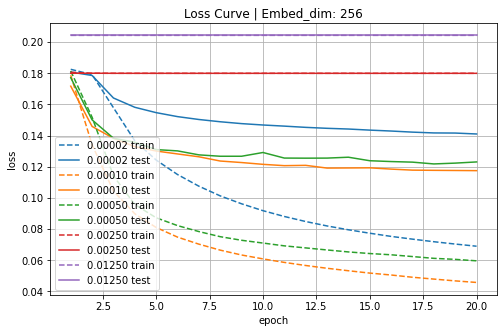

In [ ]:
plt.figure(figsize=(8,5))
for i in range(len(lr_pool)):
    plt.plot(np.arange(1, epochs + 1), train_losses[i], label=f"{lr_pool[i]:.5f} train", color=plt.cm.tab10(i), linestyle="dashed")
    plt.plot(np.arange(1, epochs + 1), eval_losses[i], label=f"{lr_pool[i]:.5f} test", color=plt.cm.tab10(i))
plt.title(f"Loss Curve | Embed_dim: {embed_dim}")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.legend(loc="lower left")
plt.savefig("lr.png", bbox_inches="tight")
plt.show()

## 3. Observation
From this experiment, we see that the learning rate 0.0025 and 0.0125 are too large for this task. Our smallest learning rate 0.00002 on the other hand may be too small, resulting in requiring too many steps to converge. If we train this model for more epochs, one strategy would be starting training with learning rate 0.0001, then changing it to 0.00002 after having no improvements for a pre-difined number of epochs.

## 4. Understanding the Learning Process
To develop our intuition about how the learning is done, we choose two learning rates and see how the embeddings are changed after one parameter update.

In [ ]:
lr1 = 0.0001 # The learning rate turned out to be good.

batch_size = 32
trainloader = DataLoader(TrainingDataset, batch_size=batch_size, shuffle=True)

image_head = EncoderHeads.EncoderHead(image_head_model, TrainingDataset.image_encoder_output_size, embed_dim).to(device)
text_head = EncoderHeads.EncoderHead(text_head_model, TrainingDataset.text_encoder_output_size, embed_dim).to(device)
# Save the initial weights so that we can use it for another learning rate setting later.
torch.save(image_head.state_dict(), "image_head")
torch.save(text_head.state_dict(), "text_head")
criterion = torch.nn.CosineEmbeddingLoss(margin=0.1, reduction='sum')
image_optimizer = torch.optim.Adam(image_head.parameters(), lr=lr1)
text_optimizer = torch.optim.Adam(text_head.parameters(), lr=lr1)

image_head.train()
text_head.train()
# Pick one batch.
for batch in trainloader:
    break

# Update the parameters two times.
image_optimizer.zero_grad()
text_optimizer.zero_grad()
image_embedding_0 = image_head(batch["images"].to(device))
text_embedding_0 = text_head(batch["texts"].to(device))
loss = criterion(image_embedding_0, text_embedding_0, batch["labels"].to(device))
loss.backward()
image_optimizer.step()
text_optimizer.step()
image_embedding_1 = image_head(batch["images"].to(device))
text_embedding_1 = text_head(batch["texts"].to(device))
loss = criterion(image_embedding_1, text_embedding_1, batch["labels"].to(device))
loss.backward()
image_optimizer.step()
text_optimizer.step()
image_embedding_2 = image_head(batch["images"].to(device))
text_embedding_2 = text_head(batch["texts"].to(device))
label = batch["labels"].cpu().numpy()

In [ ]:
image_embedding_0, text_embedding_0 = image_embedding_0.cpu().detach().numpy(), text_embedding_0.cpu().detach().numpy()
image_embedding_1, text_embedding_1 = image_embedding_1.cpu().detach().numpy(), text_embedding_1.cpu().detach().numpy()
image_embedding_2, text_embedding_2 = image_embedding_2.cpu().detach().numpy(), text_embedding_2.cpu().detach().numpy()

# For each positive and negative pairs, compute the cosine similarity
positive_0_s, negative_0_s = [], []
positive_1_s, negative_1_s = [], []
positive_2_s, negative_2_s = [], []
for i in range(batch_size):
    sim_0 = np.dot(image_embedding_0[i], text_embedding_0[i]) / (np.linalg.norm(image_embedding_0[i]) * np.linalg.norm(text_embedding_0[i]))
    sim_1 = np.dot(image_embedding_1[i], text_embedding_1[i]) / (np.linalg.norm(image_embedding_1[i]) * np.linalg.norm(text_embedding_1[i]))
    sim_2 = np.dot(image_embedding_2[i], text_embedding_2[i]) / (np.linalg.norm(image_embedding_2[i]) * np.linalg.norm(text_embedding_2[i]))
    if label[i] == 1:
        positive_0_s.append(sim_0)
        positive_1_s.append(sim_1)
        positive_2_s.append(sim_2)
    else:
        negative_0_s.append(sim_0)
        negative_1_s.append(sim_1)
        negative_2_s.append(sim_2)

In [ ]:
# Do the same computation for different learning rate.
lr2 = 0.0025 # The learning rate turned out to be too large.
image_head.load_state_dict(torch.load("image_head"))
text_head.load_state_dict(torch.load("text_head"))
image_head.train()
text_head.train()
image_optimizer = torch.optim.Adam(image_head.parameters(), lr=lr2)
text_optimizer = torch.optim.Adam(text_head.parameters(), lr=lr2)

image_optimizer.zero_grad()
text_optimizer.zero_grad()
image_embedding_0 = image_head(batch["images"].to(device))
text_embedding_0 = text_head(batch["texts"].to(device))
loss = criterion(image_embedding_0, text_embedding_0, batch["labels"].to(device))
loss.backward()
image_optimizer.step()
text_optimizer.step()
image_embedding_1 = image_head(batch["images"].to(device))
text_embedding_1 = text_head(batch["texts"].to(device))
loss = criterion(image_embedding_1, text_embedding_1, batch["labels"].to(device))
loss.backward()
image_optimizer.step()
text_optimizer.step()
image_embedding_2 = image_head(batch["images"].to(device))
text_embedding_2 = text_head(batch["texts"].to(device))
label = batch["labels"].cpu().numpy()

In [ ]:
image_embedding_0, text_embedding_0 = image_embedding_0.cpu().detach().numpy(), text_embedding_0.cpu().detach().numpy()
image_embedding_1, text_embedding_1 = image_embedding_1.cpu().detach().numpy(), text_embedding_1.cpu().detach().numpy()
image_embedding_2, text_embedding_2 = image_embedding_2.cpu().detach().numpy(), text_embedding_2.cpu().detach().numpy()

positive_0_f, negative_0_f = [], []
positive_1_f, negative_1_f = [], []
positive_2_f, negative_2_f = [], []
for i in range(batch_size):
    sim_0 = np.dot(image_embedding_0[i], text_embedding_0[i]) / (np.linalg.norm(image_embedding_0[i]) * np.linalg.norm(text_embedding_0[i]))
    sim_1 = np.dot(image_embedding_1[i], text_embedding_1[i]) / (np.linalg.norm(image_embedding_1[i]) * np.linalg.norm(text_embedding_1[i]))
    sim_2 = np.dot(image_embedding_2[i], text_embedding_2[i]) / (np.linalg.norm(image_embedding_2[i]) * np.linalg.norm(text_embedding_2[i]))
    if label[i] == 1:
        positive_0_f.append(sim_0)
        positive_1_f.append(sim_1)
        positive_2_f.append(sim_2)
    else:
        negative_0_f.append(sim_0)
        negative_1_f.append(sim_1)
        negative_2_f.append(sim_2)

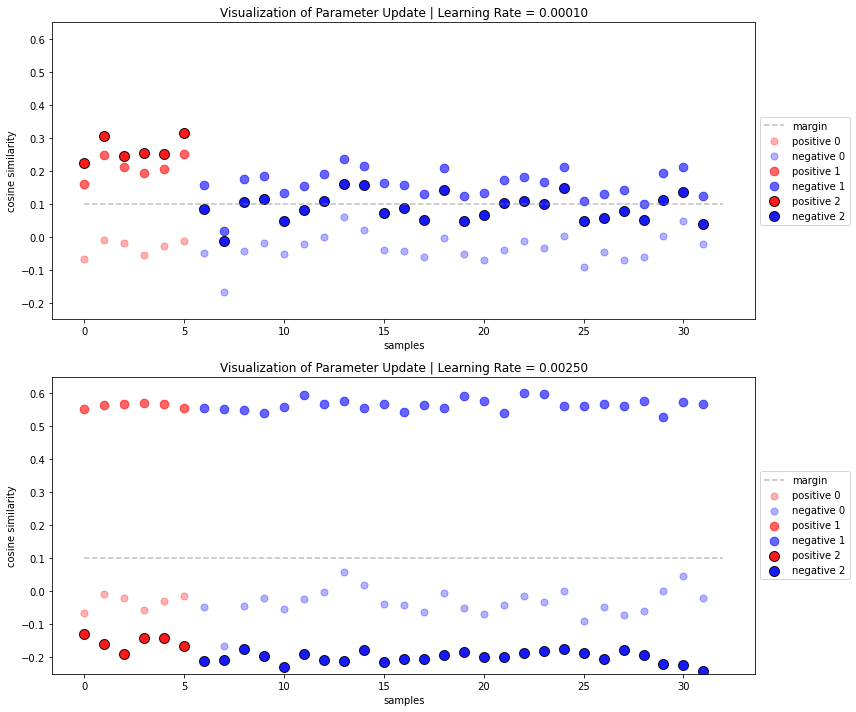

In [ ]:
# Plot the result.
plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
plt.scatter(np.arange(len(positive_0_s)), positive_0_s, color="red", alpha=0.3, s=50, label="positive 0")
plt.scatter(np.arange(len(positive_0_s), batch_size), negative_0_s, color="blue", alpha=0.3, s=50, label="negative 0")
plt.scatter(np.arange(len(positive_0_s)), positive_1_s, color="red", alpha=0.6, s=75, label="positive 1")
plt.scatter(np.arange(len(positive_0_s), batch_size), negative_1_s, color="blue", alpha=0.6, s=75, label="negative 1")
plt.scatter(np.arange(len(positive_0_s)), positive_2_s, color="red", alpha=0.9, s=100, edgecolor="black", label="positive 2")
plt.scatter(np.arange(len(positive_0_s), batch_size), negative_2_s, color="blue", alpha=0.9, s=100, edgecolor="black", label="negative 2")
plt.plot([0, batch_size], [0.1, 0.1], alpha=0.5, color="gray", linestyle="dashed", label="margin")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim([-0.25, 0.65])
plt.xlabel("samples")
plt.ylabel("cosine similarity")
plt.title(f"Visualization of Parameter Update | Learning Rate = {lr1:.5f}")

plt.subplot(2, 1, 2)
plt.scatter(np.arange(len(positive_0_f)), positive_0_f, color="red", alpha=0.3, s=50, label="positive 0")
plt.scatter(np.arange(len(positive_0_f), batch_size), negative_0_f, color="blue", alpha=0.3, s=50, label="negative 0")
plt.scatter(np.arange(len(positive_0_f)), positive_1_f, color="red", alpha=0.6, s=75, label="positive 1")
plt.scatter(np.arange(len(positive_0_f), batch_size), negative_1_f, color="blue", alpha=0.6, s=75, label="negative 1")
plt.scatter(np.arange(len(positive_0_f)), positive_2_f, color="red", alpha=0.9, s=100, edgecolor="black", label="positive 2")
plt.scatter(np.arange(len(positive_0_f), batch_size), negative_2_f, color="blue", alpha=0.9, s=100, edgecolor="black", label="negative 2")
plt.plot([0, batch_size], [0.1, 0.1], alpha=0.5, color="gray", linestyle="dashed", label="margin")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim([-0.25, 0.65])
plt.xlabel("samples")
plt.ylabel("cosine similarity")
plt.title(f"Visualization of Parameter Update | Learning Rate = {lr2:.5f}")

plt.tight_layout()
# plt.savefig("lr_2updates.png", bbox_inches="tight")
plt.show()

With good learning rate 0.0001, the cosine similarity for positive pairs increases in each update while the similarity for negative pairs increased in the first update then dropped in the second update. An intuitive explanation would be the loss was only from positive pairs in the first update due to the margin. In the second update however, the loss was also from negative pairs, penalizes the negative pairs. <br>
In the bottom plot, both positive and negative pairs behave nearly the same in each update. In the first update, the loss was generated only from the positive pairs again, and the corresponding update made all pairs close each other. Then in the second step, the loss was dominated by the ones from negative pairs, forcing all the pairs separated. Though further investigation is needed to fully understand the learning process, this is our hypothesis why training is successful with small enough learning rate and why training never converges with too large learning rate.